# Inertial Estimation with Imu Preintegration

## Background

IMUs are powerful sensors capable of providing us with measurements on angular velocity and linear acceleration of the body at an incredibly high frequency (~200Hz and above). To estimate the pose of the body at any time, one can simply integrate the angular velocity to get the rotation and double-integrate the linear acceleration to get the velocity and translation.

$$ R^w_b = \int^{t_j}_{t_i} \hat{\omega} dt $$
$$ v^w = \int^{t_j}_{t_i} \hat{a} dt $$
$$ t^w = \int^{t_j}_{t_i}\int^{t_j}_{t_i} \hat{a} dt $$

where $\hat{\omega}$ is the measured angular velocity and $\hat{a}$ is the measured linear acceleration.

Alas, things are not as straightforward as this. Unless you are using tactical or navigation grade IMUs (which cost \$1000s), the sensor measurements will be incredibly noise and affected by sensor bias $(b_{\omega}, b_{a})$ that will cause the estimates to drift away from the true values. To correct for this, we need to optimize with consideration for the noise and bias values as part of our model.

However, performing optimization at 200 Hz is a bit unrealistic and can quickly overwhelm the system, especially when we only need estimates every, e.g. 50 Hz. Can we instead account for multple measurements between two estimation timestamps as a single binary constraint? The answer is yes and the methodology for that is developed in the [paper by Forster et. al.](https://arxiv.org/pdf/1512.02363.pdf) which is termed as **IMU Preintegration**.

Luckily for us, GTSAM has the `ImuFactor` which performs IMU preintegration for us in a neatly tied package, such that all we need to consider is the coordinate frame of the sensor with respect to the body, and providing the measurements for preintegration.

## Objectives

In this example, we shall examine how to use IMU preintegration for inertial estimation with factor graphs. Given a sequence of measurements, we will construct the factor graph and optimize it in order to get the desired pose estimates.

In [1]:
# Install the pre-requisites
%pip -q install gtbook ipympl  # also installs latest gtsam pre-release

import numpy as np
import gtsam
from gtsam.utils.plot import plot_pose3
from matplotlib import pyplot as plt
from gtsam.symbol_shorthand import B, V, X

%matplotlib widget

Note: you may need to restart the kernel to use updated packages.


## Example Trajectory

Let's first generate an example trajectory we wish to estimate, as this will give us a good sense of what we want. We'll also visualize the trajectory with a little helper function.

In [2]:
T = 12  # The timespan of our trajectory.
dt = 0.005  # 200 Hz frequency
velocity = np.array([2, 0, 0])  # The velocity we wish to move at.

scenarios = {
            "zero_motion" : (np.zeros(3), np.zeros(3)),
            "forward_motion" : (np.zeros(3), velocity),
            "loop": (np.array([0, -np.radians(30), 0]), velocity),
            "sick": (np.array([np.radians(30), -np.radians(30),
                                  0]), velocity)
}

def plot_scenario(scenario, T, dt, POSES_FIG=0, maxDim = 5):
    """Plot the `scenario` trajectory over `T` seconds."""
    for t in np.arange(0, T, dt):
        actualPose = scenario.pose(t)
        plot_pose3(POSES_FIG, actualPose, axis_length=0.3)
        
        translation = actualPose.translation()
        maxDim = max([max(np.abs(translation)), maxDim])
        ax = plt.gca()
        ax.set_xlim3d(-maxDim, maxDim)
        ax.set_ylim3d(-maxDim, maxDim)
        ax.set_zlim3d(-maxDim, maxDim)

    plt.show()

We can now plot the various scenarios, e.g. forward motion.

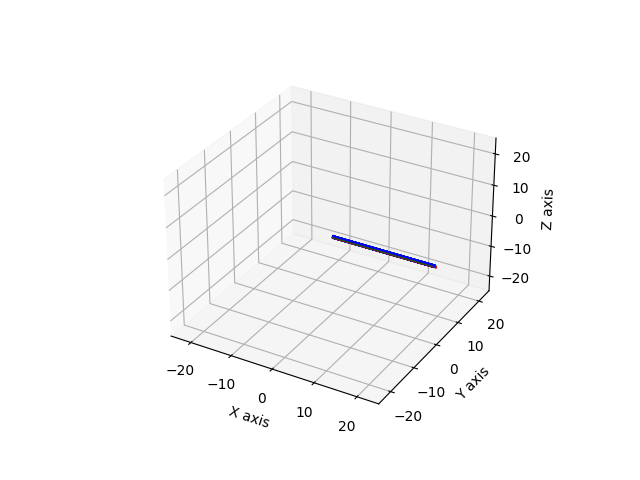

In [3]:
scenario = gtsam.ConstantTwistScenario(*scenarios["forward_motion"])
plot_scenario(scenario, T, dt, 1)

Since we don't want to tackle a trajectory with a trivial solution, let's pick the __loop__ scenario as our trajectory.

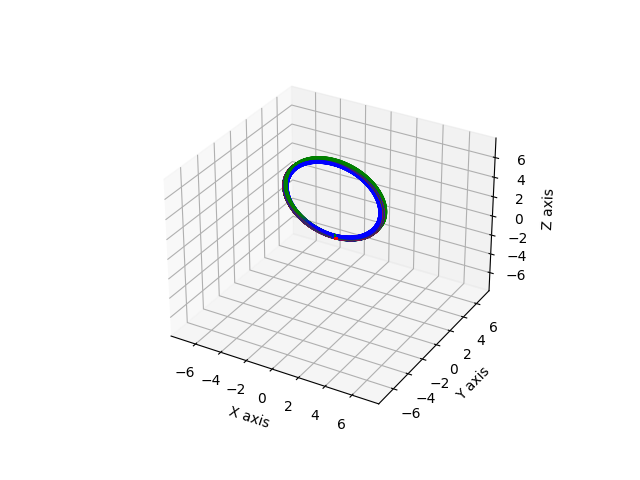

In [4]:
scenario = gtsam.ConstantTwistScenario(*scenarios["loop"])

# Let's visualize it for our understanding
plot_scenario(scenario, T, dt, 2)

As a  final step in creating the example, let's define the true IMU biases.

In [5]:
accBias = np.array([-0.3, 0.1, 0.2])
gyroBias = np.array([0.1, 0.3, -0.1])
actualBias = gtsam.imuBias.ConstantBias(accBias, gyroBias)


## IMU Preintegration

To perform preintegration, GTSAM conveniently provides us with an object called `PreintegratedImuMeasurements`. This object requires various parameters such as the sensor covariances, an initial estimate of the bias, and a potential tranform `bodyPsensor` is the IMU is not coincidental with the body frame.

We begin with specifying that the IMU has the Z axis pointing up. This is important since reaction to gravity is an acceleration that is measured by the IMU, and making a mistake here can throw our entire system into jeopardy easily. We also specify some nominal covariance values, though these would depend on the IMU itself.

 Also, let's create a `ScenarioRunner` which is a helper object to get us the measurements as well as other parameters we need during the main data loop.

In [6]:
params = gtsam.PreintegrationParams.MakeSharedU(9.81)

# Some arbitrary noise sigmas
gyro_sigma = 1e-3
accel_sigma = 1e-3
I_3x3 = np.eye(3)
params.setGyroscopeCovariance(gyro_sigma**2 * I_3x3)
params.setAccelerometerCovariance(accel_sigma**2 * I_3x3)
params.setIntegrationCovariance(1e-7**2 * I_3x3)

# Define the PreintegratedImuMeasurements object here.
pim = gtsam.PreintegratedImuMeasurements(params, actualBias)

runner = gtsam.ScenarioRunner(scenario, params, dt, actualBias)

## Factor Graph

We are now ready to generate our factor graph. The `scenario` object will provide us with the measurements, and we will add a prior on the pose and the velocity to ensure our graph is not singular.

In [7]:
graph = gtsam.NonlinearFactorGraph()
initial = gtsam.Values()

Let's add in the priors to our graph as well as some initial estimates.

In [8]:
# Noise models for
priorNoise = gtsam.noiseModel.Isotropic.Sigma(6, 0.1)
velNoise = gtsam.noiseModel.Isotropic.Sigma(3, 0.1)

initial_state = scenario.navState(0)
graph.push_back(gtsam.PriorFactorPose3(X(0), initial_state.pose(), priorNoise))
graph.push_back(gtsam.PriorFactorVector(V(0), initial_state.velocity(), velNoise))

initial.insert(B(0), actualBias)
initial.insert(X(0), initial_state.pose())
initial.insert(V(0), initial_state.velocity())


At this point, we have everything set up and we can run the main loop where we accept the IMU measurements and create our `ImuFactor`s.

In [9]:
# The factor index for the estimation rate
i = 0

for k, t in enumerate(np.arange(0, T, dt)):
    # get measurements and add them to PIM
    measuredOmega = runner.measuredAngularVelocity(t)
    measuredAcc = runner.measuredSpecificForce(t)
    pim.integrateMeasurement(measuredAcc, measuredOmega, dt)

    if (k + 1) % int(1 / dt) == 0:
        # Create IMU factor every second.
        factor = gtsam.ImuFactor(X(i), V(i), X(i + 1), V(i + 1), B(0), pim)
        graph.push_back(factor)

        # We have created the binary constraint, so we clear out the preintegration values.
        pim.resetIntegration()

        # Get the true state which we will corrupt with some additive noise terms defined below
        actual_state_i = scenario.navState(t + dt)

        # These are additive noise terms.
        rotationNoise = gtsam.Rot3.Expmap(np.random.randn(3) * 0.1)
        translationNoise = gtsam.Point3(*np.random.randn(3) * 1)
        poseNoise = gtsam.Pose3(rotationNoise, translationNoise)

        noisy_state_i = gtsam.NavState(
            actual_state_i.pose().compose(poseNoise),
            actual_state_i.velocity() + np.random.randn(3) * 0.1)

        initial.insert(X(i + 1), noisy_state_i.pose())
        initial.insert(V(i + 1), noisy_state_i.velocity())
        i += 1

We want to visualize our initial estimates, so let's create a small function to do so and plot out the initial trajectory based only on pure forward-integration. You will see that the initial estimates don't look like anything close to the true trajectory!

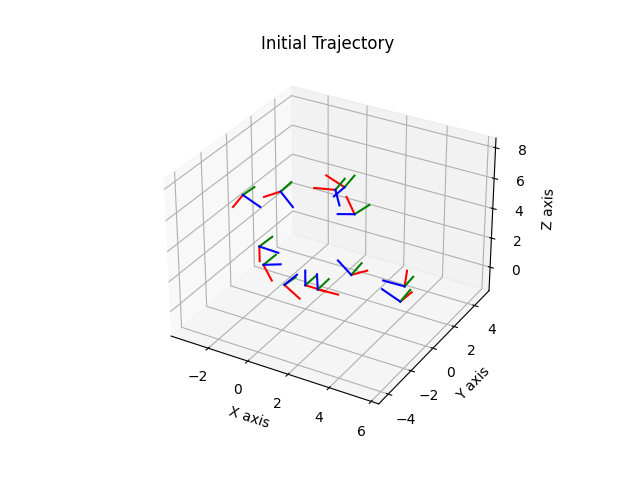

In [13]:
def plot_trajectory(values: gtsam.Values,
                    title: str = "Estimated Trajectory",
                    fignum: int = 1,
                    show: bool = False):
    """
        Plot poses in values.

        Args:
            values: The values object with the poses to plot.
            title: The title of the plot.
            fignum: The matplotlib figure number.
                POSES_FIG is a value from the PreintegrationExample which we simply increment to generate a new figure.
            show: Flag indicating whether to display the figure.
        """
    i = 0
    while values.exists(X(i)):
        pose_i = values.atPose3(X(i))
        plot_pose3(fignum, pose_i, 1)
        i += 1
    plt.title(title)

    gtsam.utils.plot.set_axes_equal(fignum)

    plt.ioff()

    if show:
        plt.show()


plot_trajectory(initial, title="Initial Trajectory", fignum=5, show=True)

## Optimization

Now that we have a full factor graph and initial estimates, we can optimize for the correct estimates. This is as simple as just initializing an optimizer with the graph and initial values and calling `optimize` on it.

In [11]:
params = gtsam.LevenbergMarquardtParams()
params.setVerbosityLM("SUMMARY")
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial, params)
result = optimizer.optimize()

Initial error: 2.09506e+08, values: 27
iter      cost      cost_change    lambda  success iter_time
   0  1.350947e+06    2.08e+08    1.00e-05     1    3.00e-04
   1  2.010667e+02    1.35e+06    1.00e-06     1    2.23e-04
   2  2.779001e-06    2.01e+02    1.00e-07     1    2.20e-04
   3  4.143465e-22    2.78e-06    1.00e-08     1    2.20e-04


## Final Result

Now that we have our final `result` values, we can visualize the result and see that our estimates are actually quite good.

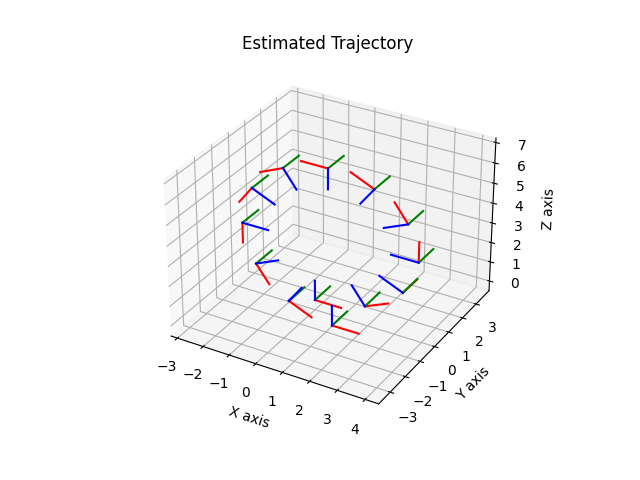

In [12]:
plot_trajectory(result, fignum=6, show=True)

## Conclusion

There you have it! Using the `PreintegratedImuMeasurements` object and combining it with the `ImuFactor` gives us a powerful and efficient mechanism for performing inertial estimation.